In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import os


In [2]:
dirname = os.path.abspath('')
checkpoint = "/home/thebird/repos/sam2//checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

In [3]:
# Helper functions

np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=False):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        # it plots the image
        # then adds the mask and detection box on top of the image graph
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

def show_masks_multiple(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=False):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for i, (mask, score) in enumerate(zip(masks, scores)):
        show_mask(mask, plt.gca(), borders=borders)
        # if point_coords[i] is not None:
        #     assert input_labels[i] is not None
        #     show_points(point_coords[i], input_labels[i], plt.gca())
        if box_coords[i] is not None:
            # boxes
            show_box(box_coords[i], plt.gca())
        if len(scores[i]) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  


In [ ]:
# sam2 helper functions

def get_batch_input_boxes(detectionsInImage):
    input_boxes = []
    input_points = []
    input_labels = []
    for detection in detectionsInImage:
        input_boxes.append(np.array(detection.xyxy[0].cpu()))
        input_points.append(np.array([detection.xywh[0][0:2].cpu()]))
        input_labels.append(np.array([1]))
    return input_boxes, input_points, input_labels

predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint, device="cuda"))

def sam2_FramePrediction_single(image=None, input_point=None, input_label=None):
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label)
    return masks, scores, logits

def sam2_FramePredictionMultipleMasks(image=None, input_boxes=None, input_labels=None, input_points=None):
    predictor.set_image(image)
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        box=input_boxes,
        multimask_output=False,
    )
    return masks, scores, logits

In [5]:
image = Image.open("/home/thebird/Dynamworks/LLM_Module/Hackathon/Vehicle_Detection_Image_Dataset/sample_image.jpg")
input_point = np.array([[500, 375]])
input_label = np.array([1])
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    masks, scores, logits = sam2_FramePrediction_single(image=image,
                                input_point=input_point,
                                input_label=input_label) 

In [6]:
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

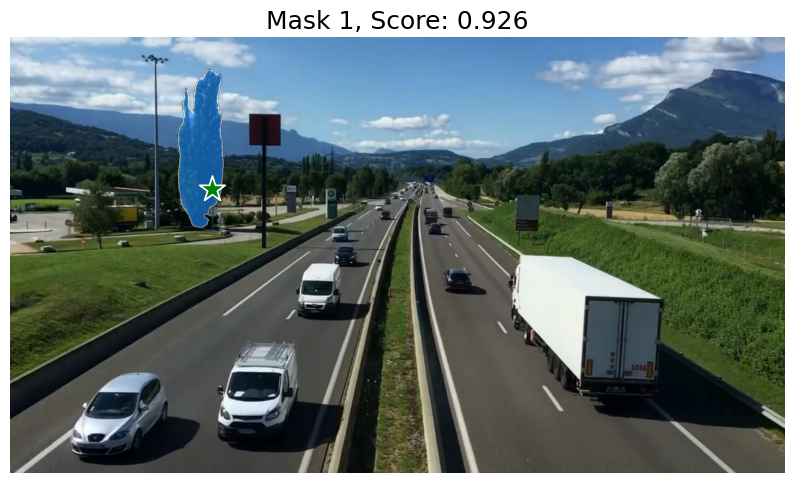

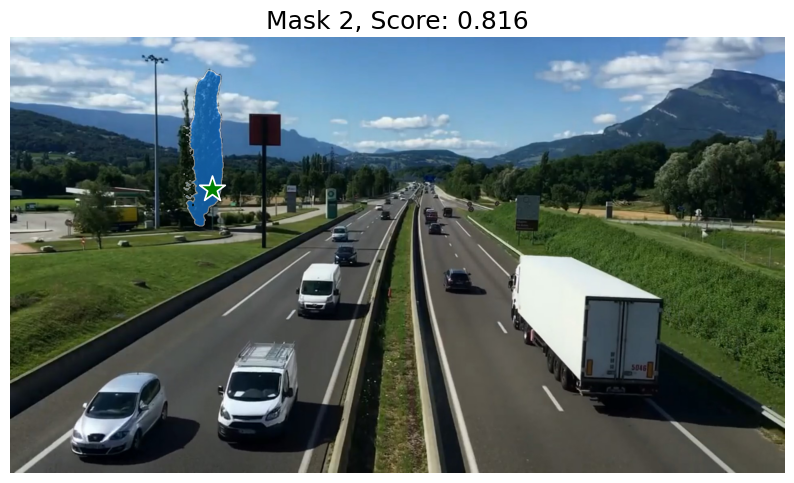

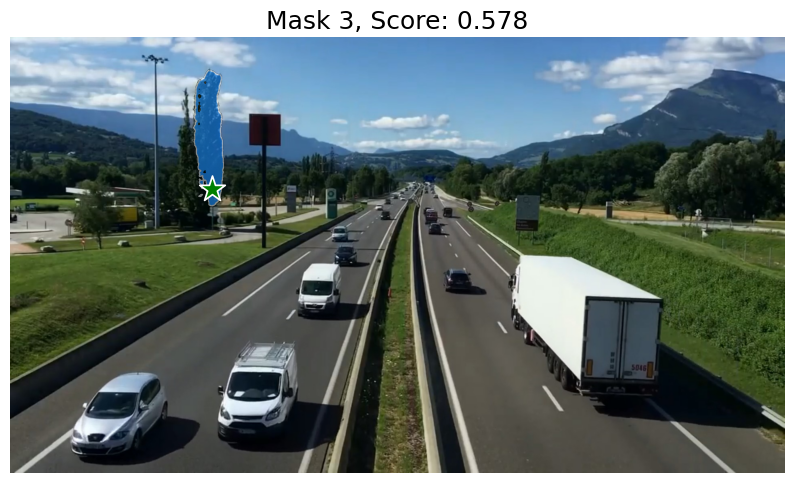

In [7]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

In [8]:
from ultralytics import YOLO

# model = YOLO('yolov8n.pt')
# model = YOLO('/home/thebird/Dynamworks/LLM_Module/Hackathon/runs/detect/train/weights/last.pt')
model = YOLO('/home/thebird/Dynamworks/LLM_Module/Hackathon/runs/detect/train/weights/best.pt')
model.fuse()

Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


In [9]:
# img_path = "/home/thebird/Dynamworks/LLM_Module/Hackathon/Vehicle_Detection_Image_Dataset/sample_image.jpg"
img_path = "/home/thebird/Dynamworks/LLM_Module/Hackathon/Vehicle_Detection_Image_Dataset/valid/images/5_mp4-29_jpg.rf.de506ae3402dafeffb1e6427af894871.jpg"
image = Image.open(img_path)

detections = model.predict(image, conf=0.7)


0: 640x640 15 Vehicles, 4.7ms
Speed: 4.6ms preprocess, 4.7ms inference, 22.2ms postprocess per image at shape (1, 3, 640, 640)


In [10]:
print(len(detections[0].boxes))

15


In [11]:
input_box, input_point, input_label = get_batch_input_boxes(detections[0].boxes)
print(input_box)
print(input_point)
print(input_label)

[array([     107.59,      526.48,      232.83,      636.17], dtype=float32), array([     441.54,      398.11,      531.38,      481.45], dtype=float32), array([     191.05,      428.86,      289.02,       515.1], dtype=float32), array([          0,      317.04,      49.959,      370.07], dtype=float32), array([     106.83,      324.25,      174.15,       382.6], dtype=float32), array([     305.91,      329.54,      377.43,       392.8], dtype=float32), array([     185.23,      377.09,      263.44,      439.34], dtype=float32), array([     436.37,      258.41,      489.78,      304.42], dtype=float32), array([       34.1,      283.24,      91.561,       327.1], dtype=float32), array([     198.46,      338.16,      268.72,      393.21], dtype=float32), array([     215.69,      290.72,      280.17,      345.14], dtype=float32), array([     235.97,      257.17,      286.06,      290.76], dtype=float32), array([     127.72,      222.83,      162.46,      252.97], dtype=float32), array([    

In [12]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

/home/thebird/anaconda3/envs/dynamworks_hackathon/lib/python3.10/site-packages/sam2/sam2_image_predictor.py:314: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  point_coords = torch.as_tensor(
/home/thebird/anaconda3/envs/dynamworks_hackathon/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/thebird/anaconda3/envs/dynamworks_hackathon/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)

In [14]:
# show_masks(image, masks, scores, box_coords=input_box, point_coords=input_point, input_labels=input_label)

In [15]:
input_boxes, input_points, input_labels = get_batch_input_boxes(detections[0].boxes)

In [16]:
print(input_boxes)
print(input_points)
print(input_labels)


[array([     107.59,      526.48,      232.83,      636.17], dtype=float32), array([     441.54,      398.11,      531.38,      481.45], dtype=float32), array([     191.05,      428.86,      289.02,       515.1], dtype=float32), array([          0,      317.04,      49.959,      370.07], dtype=float32), array([     106.83,      324.25,      174.15,       382.6], dtype=float32), array([     305.91,      329.54,      377.43,       392.8], dtype=float32), array([     185.23,      377.09,      263.44,      439.34], dtype=float32), array([     436.37,      258.41,      489.78,      304.42], dtype=float32), array([       34.1,      283.24,      91.561,       327.1], dtype=float32), array([     198.46,      338.16,      268.72,      393.21], dtype=float32), array([     215.69,      290.72,      280.17,      345.14], dtype=float32), array([     235.97,      257.17,      286.06,      290.76], dtype=float32), array([     127.72,      222.83,      162.46,      252.97], dtype=float32), array([    

In [17]:
masks, scores, _ = sam2_FramePredictionMultipleMasks(image=image, input_boxes=input_boxes, input_labels=input_labels, input_points=input_points)

In [18]:
masks.shape

(15, 1, 640, 640)

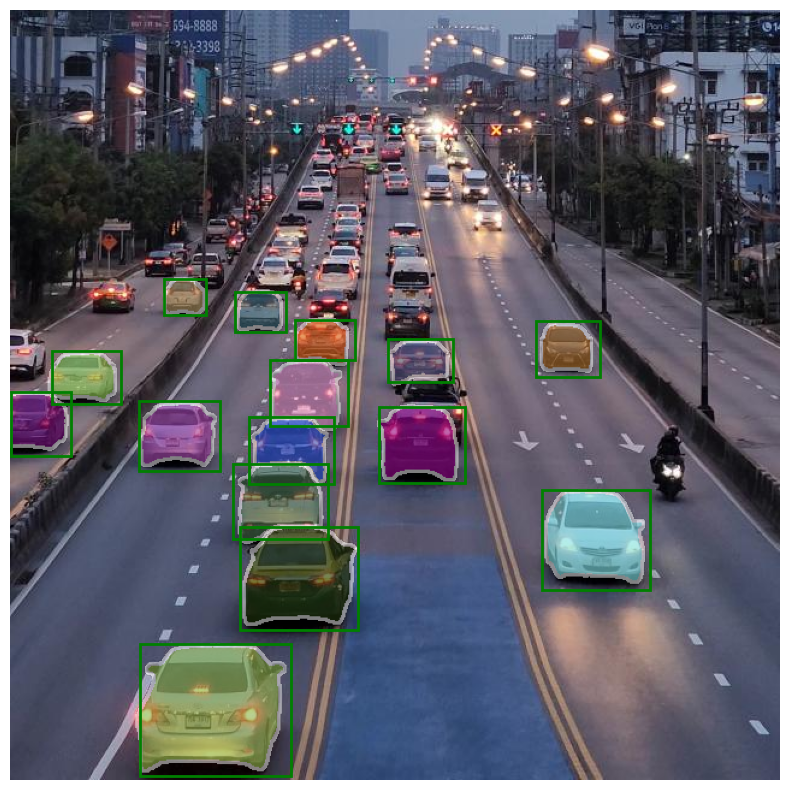

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

In [27]:

# Define the path to the sample video in the dataset
dataset_video_path = os.path.join(dirname, 'Vehicle_Detection_Image_Dataset/sample_video.mp4')

# Define the destination path in the working directory
video_path = os.path.join(dirname, 'working/sample_video_yolo_sam2.mp4')

# Copy the video file from its original location in the dataset to the current working directory in Kaggle for further processing
# shutil.copyfile(dataset_video_path, video_path)


0: 384x640 3 Vehicles, 5.3ms
Speed: 9.0ms preprocess, 5.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


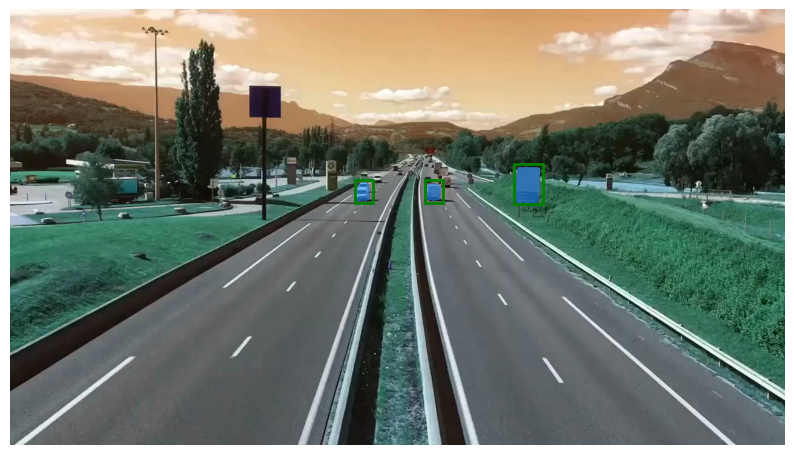

ValueError: mask must be a 3D np.ndarray with shape (1, H, W), but got shape (3, 1, 720, 1280)

In [54]:
import cv2
import supervision as sv
from ultralytics import SAM

sam_model = SAM("sam2_l.pt")
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

cap = cv2.VideoCapture(dataset_video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video = cv2.VideoWriter(video_path, fourcc, 15.0, (width, height))

while True:
    success, frame = cap.read()
    if frame is None:
        break # end of video_path

    # frame = cv2.resize(frame,(640,640))
    prediction_result = model.predict(frame, conf=0.7)
    # # for result in prediction_result:
    # class_ids = prediction_result.boxes.cls.int().tolist()  # noqa
    # if len(class_ids):
    #     boxes = prediction_result.boxes.xyxy  # Boxes object for bbox outputs
    #     sam_results = sam_model(prediction_result.orig_img, bboxes=boxes, verbose=False, save=True, device=0)
    # print(sam_results[0].obb)
    # output_video.write(sam_results[0].orig_img)
    input_boxes, input_points, input_labels = get_batch_input_boxes(prediction_result[0].boxes)
    masks, scores, logits = sam2_FramePredictionMultipleMasks(image=frame,
                                                         input_boxes=input_boxes,
                                                         input_labels=input_labels,
                                                         input_points=input_points)
    show_masks_multiple(frame, masks, scores, box_coords=input_boxes, point_coords=input_points, input_labels=input_labels)
    annotated_frame = frame.copy()
    for m in masks:
        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=m),
            mask=masks.astype(bool)
        )
        annotated_frame = mask_annotator.annotate(scene=annotated_frame, detections=detections)
    output_video.write(annotated_frame)
    # break

cap.release()
output_video.release()

In [ ]:
from ultralytics.data.annotator import auto_annotate

auto_annotate(data="/home/thebird/Dynamworks/LLM_Module/Hackathon/Vehicle_Detection_Image_Dataset/sample_image.jpg", det_model="yolov8n.pt", sam_model="sam2_l.pt")


image 1/1 /home/thebird/Dynamworks/LLM_Module/Hackathon/Vehicle_Detection_Image_Dataset/sample_image.jpg: 384x640 9 cars, 13.4ms
Speed: 2.0ms preprocess, 13.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
